In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import ot
from scipy.spatial.distance import cdist

from scipy.stats import multivariate_normal as mvn
from matplotlib import cm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

data_folder = 'D:\\MNIST-digits\\'

images = np.load(data_folder+"mnist_data.npy")
labels = np.load(data_folder+"mnist_labels.npy", allow_pickle=True)

# Assuming you have mnist_data and mnist_labels as NumPy arrays
# Convert them to PyTorch tensors
mnist_data = torch.tensor(images, dtype=torch.float32)

# Create a TensorDataset by combining data and labels
mnist_dataset = TensorDataset(mnist_data)

# Set your batch size and whether to shuffle the data
batch_size = 64
shuffle = True

# Create a DataLoader using the TensorDataset
train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

In [4]:
class autoencoder_basic(nn.Module):
    def __init__(self, nb_channels, latent_dim):
        super(autoencoder_basic, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, latent_dim, kernel_size=4),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, nb_channels, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),
        )
        
    def forward(self, x):
        h = self.encoder(x)
        return self.decoder(h)

    def loss(self, reconstructed_x, x):
        return F.mse_loss(reconstructed_x, x)
            
        


In [5]:
nb_channels = 64
latent_dim = 20

learning_rate = 1e-3

# Instantiate the model
model = autoencoder_basic(nb_channels, latent_dim).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 5, Average Loss: 6.0868357596261164


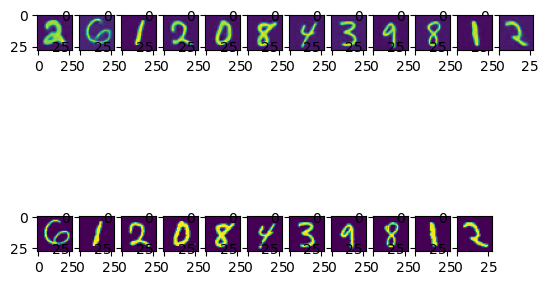

In [ ]:
from IPython.display import clear_output
num_epochs = 100  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_data in train_loader:  # Iterate over batches        
        inputs = batch_data[0].view(-1, 1, 28, 28).to(device)
        
        optimizer.zero_grad()

        # Forward pass
        reconstructed_batch = model(inputs)
        
        # Compute the loss
        loss = model.loss(reconstructed_batch, inputs)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print or log the average loss for the epoch\
    clear_output(wait=True)
    print(f'Epoch {epoch + 1}, Average Loss: {total_loss / 70000}')
    for i in range(12):
        plt.subplot(2,12,i+1)
        plt.imshow(reconstructed_batch[i].reshape(28,28).detach().cpu().numpy())
        plt.subplot(2,12,i+12)
        plt.imshow(inputs[i].reshape(28,28).detach().cpu().numpy())
    plt.show()

In [ ]:
# class variational_autoencoder(nn.Module):
#     def __init__(self, nb_channels, latent_dim):
#         super(variational_autoencoder, self).__init__()
        
#         self.latent_dim = latent_dim
#         param_dim = int(latent_dim + (latent_dim*(latent_dim+1)/2) )
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, nb_channels, kernel_size=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(nb_channels, param_dim, kernel_size=4),
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(latent_dim, nb_channels, kernel_size=4),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),
#         )
        
    
        
#     def forward(self, x):
#         h = self.encoder(x)
#         mu, triu = h[:, :self.latent_dim], h[:, self.latent_dim:]
#         covariance = self.get_cov(triu)
#         z = self.reparameterize(mu, covariance)
#         return self.decoder(z), mu, covariance

    
#     def get_cov(self, triu):
#         upper_triangular_matrices = torch.zeros((triu.shape[0], self.latent_dim, self.latent_dim)).to(device)
#         upper_triangular_matrices[:,torch.triu_indices(self.latent_dim,self.latent_dim)[0],torch.triu_indices(self.latent_dim,self.latent_dim)[1]] = triu.reshape(triu.shape[0],triu.shape[1])
#         symmetric_matrices = upper_triangular_matrices + upper_triangular_matrices.transpose(-2, -1) - upper_triangular_matrices*torch.eye(self.latent_dim).to(device)
#         return torch.matrix_exp(symmetric_matrices)

#     def reparameterize(self, mu, covariances):   
#         std_normal = torch.randn_like(mu.reshape(mu.shape[0],mu.shape[1]))
#         return mu + torch.matmul(covariances, std_normal.unsqueeze(-1)).squeeze(-1).reshape(mu.shape[0],mu.shape[1],1,1)
    
# #     def kl_divergence(self, mu, covariance):
# #         mu = mu.reshape(mu.shape[0],mu.shape[1])

# #         N,d = mu.shape
# #         # cov_det = torch.det(covariance)
# #         cov_det_sign, cov_det_logabs = torch.slogdet(covariance)
# #         cov_det = cov_det_sign * torch.exp(cov_det_logabs)
# #         cov_inv = torch.inverse(covariance)

# #         # Trace of the covariance matrix
# #         trace_term = torch.einsum('nii->n', covariance)
        
# #         # Term involving mean and covariance
# #         mu_reshaped = mu.reshape(N, d, 1)
# #         mean_cov_term = torch.matmul(torch.matmul(mu_reshaped.permute((0, 2, 1)), torch.pinverse(covariance)), mu_reshaped).flatten()

# #         # KL Divergence
# #         kl_div = 0.5 * (trace_term + mean_cov_term - d + torch.log(cov_det))
        
# #         # kl_div[torch.isnan(kl_div)] = 100000
                
# #         return kl_div
    
#     def kl_divergence(self, mu, covariance):
#         mu = mu.reshape(mu.shape[0], mu.shape[1])

#         N, d = mu.shape

#         # Ensure that the covariance matrix is positive definite
#         eps = 1e-6
#         covariance = covariance + eps * torch.eye(d).to(covariance.device)

#         cov_det_sign, cov_det_logabs = torch.slogdet(covariance)
#         log_cov_det = cov_det_sign * cov_det_logabs

#         cov_inv = torch.inverse(covariance)

#         # Trace of the covariance matrix
#         trace_term = torch.einsum('nii->n', covariance)

#         # Term involving mean and covariance
#         mu_reshaped = mu.reshape(N, d, 1)
#         mean_cov_term = torch.matmul(torch.matmul(mu_reshaped.permute((0, 2, 1)), torch.inverse(covariance)), mu_reshaped).flatten()

#         # KL Divergence
#         kl_div = 0.5 * (trace_term + mean_cov_term - d + log_cov_det)

#         return kl_div

#     def loss(self, recon_x, x, mu, covariance):
#         # Reconstruction Loss (Mean Squared Error)
#         recon_loss = F.mse_loss(recon_x, x, reduction='sum')

#         # KL Divergence
#         # kl_loss = torch.sum(self.kl_divergence(mu, covariance))

#         # Total Loss
#         total_loss = recon_loss #+ kl_loss

#         return total_loss

In [ ]:
# nb_channels = 65
# latent_dim = 10

# learning_rate = 1e-4

# # Instantiate the model
# model = variational_autoencoder(nb_channels, latent_dim).to(device)

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# num_epochs = 100  # Adjust as needed

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch_data in train_loader:  # Iterate over batches        
#         inputs = batch_data[0].view(-1, 1, 28, 28).to(device)
        
#         optimizer.zero_grad()

#         # Forward pass
#         reconstructed_batch, mu, covariance = model(inputs)
        
#         # Compute the loss
#         loss = model.loss(reconstructed_batch, inputs, mu, covariance)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     # Print or log the average loss for the epoch\
#     print(f'Epoch {epoch + 1}, Average Loss: {total_loss / 70000}')
#     plt.imshow(reconstructed_batch[0].reshape(28,28).detach().cpu().numpy())
#     plt.show()

In [ ]:
plt.imshow(reconstructed_batch[0].reshape(28,28).detach().cpu().numpy())